## Introducción a pre-trained models, transfer learning and fine tuning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_3/notebooks/Nb_3a_Introduccion_transfer_learning_finetuning.ipynb)

En este notebook encontrarás material introductorio para entender los conceptos de modelos preentrenados, transferencia de aprendizaje y ajuste fino. Y cómo estos, empleados de forman correcta, pueden aumentar el rendimiento de tus modelos.

## Transfer Learning y fine tuning en tareas de Visión por Computadora

**Modelos preentrenados**

En esta sección, utilizaremos el modelo pre-entrenado [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16), el cual es una red convolucional que es usada para reconocimiento de imágenes. Este modelo fue entrenado con ImageNet, por lo cual es un modelo bastante robusto.

#### Objetivo:
- El objetivo será cargar dicho modelo pre-entrenado y utilizarlo sobre el dataset [MNIST](https://www.tensorflow.org/datasets/catalog/mnist), el cual contiene 70.000 imagenes de digitos escritos a mano. Así, poder clasificar dichos números con nuestro modelo entrenado previamente.

In [20]:
#@title Importar librerías
# Importamos las librerias a utilizar
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors


%matplotlib inline

In [ ]:
#@title Definir funciones complementarias
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def cosine_similarity(vec_a, vec_b):
  """Compute cosine similarity between vec_a and vec_b"""
  return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

In [40]:
# Cargamos el dataset MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape:  (60000, 28, 28)
Test shape:  (10000, 28, 28)


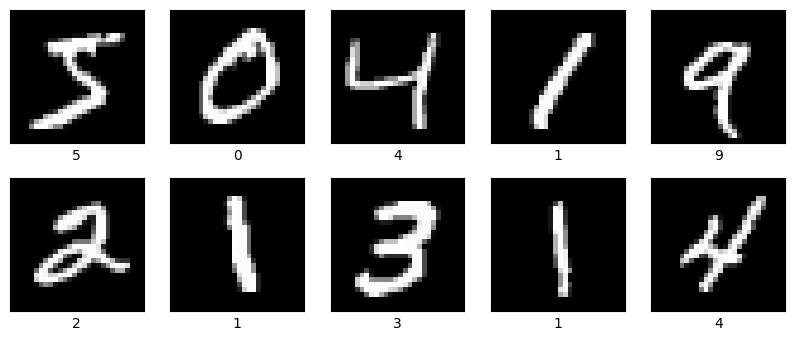

In [41]:
# dibujamos ciertos ejemplos de entrenamiento
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.gray)
    plt.xlabel(train_labels[i])
plt.show()

In [42]:
# Redimensionamos las imagenes a 32x32 (el minimo tamaño que soporta vgg16)
train_images = tf.image.grayscale_to_rgb(tf.expand_dims(train_images, axis=-1))
test_images = tf.image.grayscale_to_rgb(tf.expand_dims(test_images, axis=-1))
# Agregamos 3 canales de color (RGB) debido a que la red tambien lo necesita
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])
# Normalizamos las imagenes entre [0, 1] para que el aprendizaje sea mas suave
train_images = train_images / 255.0
test_images = test_images / 255.0
print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (60000, 32, 32, 3)
Test shape:  (10000, 32, 32, 3)


In [43]:
# Convertimos las etiquetas a formato one-hot encoding
train_labels_ohc = to_categorical(train_labels, 10)
test_labels_ohc = to_categorical(test_labels, 10)
print(train_labels_ohc[:,1])

[0. 0. 0. ... 0. 0. 0.]


In [44]:
# Cargamos el modelo VGG16 preentrenado, excluyendo las capas superiores (top=False)
# Recuerde que las capas superiores son las que definen el tipo de problema a solucionar
# Como nuestro problema es de 10 categorias (10 digitos), agregaremos nuestras propias capas superiores
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg16_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Ahora congelamos los pesos del modelo, pues solo queremos agrega una nueva capa
# con 10 neuronas, donde cada una representará el digito que queremos predecir
vgg16_base.trainable = False
model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 clases de salida
])

In [46]:
# Compilamos y entrenamos los pesos de nuestra última capa

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels_ohc, epochs=5,
                    batch_size=64, validation_data=(test_images, test_labels_ohc))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5637 - loss: 1.3788 - val_accuracy: 0.8660 - val_loss: 0.5480
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8074 - loss: 0.6335 - val_accuracy: 0.8987 - val_loss: 0.4118
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8268 - loss: 0.5544 - val_accuracy: 0.9122 - val_loss: 0.3555
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8435 - loss: 0.5003 - val_accuracy: 0.9188 - val_loss: 0.3225
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8462 - loss: 0.4836 - val_accuracy: 0.9213 - val_loss: 0.3020


In [47]:
# Medimos la precisión del modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_images, test_labels_ohc)

print(f"Precisión en el conjunto de prueba: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9123 - loss: 0.3243
Precisión en el conjunto de prueba: 0.9212999939918518


In [48]:
# Mostramos el modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,730,080 (56.19 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 10,262 (40.09 KB)

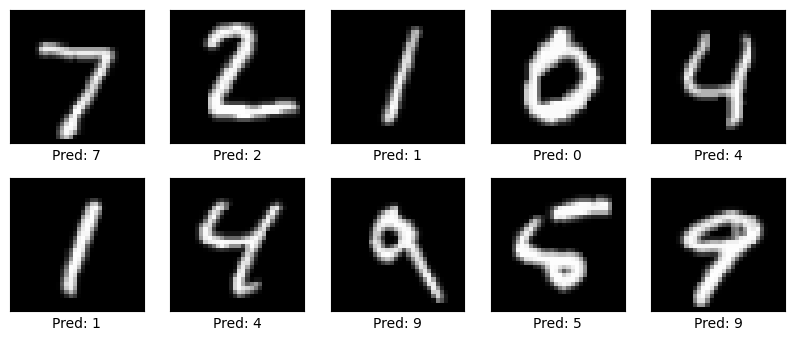

In [49]:
# Dibujamos ciertas imágenes con sus predicciones
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i], cmap=plt.cm.gray)
    pred = np.argmax(model.predict(np.expand_dims(test_images[i], axis=0), verbose=False))
    plt.xlabel(f"Pred: {pred}")
plt.show()

### Observaciones:

*   Note que al cargar un modelo pre-entrenado, logramos tener unos pesos que ya saben encontrar ciertos tipos de características dentro de las imágenes. Es por ello que cuando entrenamos nuestra capa superior (10 neuronas), solo hacen falta 5 épocas para alcanzar un accuracy del 92.14% en el conjunto de prueba.
* Cabe resaltar que utilizamos un modelo pre-entrenado y agregamos una capa superior para adaptarlo a nuestro problema. Esto se podría considerar *transfer learning* tambien.


**Modelos preentrenados**

Para dejar mas claro el concepto de *transfer learning* lo que haremos es coger el mismo modelo definido anteriormente, solo que esta vez si entrenaremos los pesos del modelo pre-entrenado, para así alcanzar un mejor rendimiento.

In [50]:
# Definimos el modelo, especificando que queremos entrenar el modelo VGG16
vgg16_base.trainable = True
model_2 = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 clases de salida
])

In [51]:
# Compilamos y entrenamos los pesos de nuestra última capa

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_2.fit(train_images, train_labels_ohc, epochs=5,
                    batch_size=64, validation_data=(test_images, test_labels_ohc))

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 57s 51ms/step - accuracy: 0.4027 - loss: 1.5865 - val_accuracy: 0.9827 - val_loss: 0.0779
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 68s 43ms/step - accuracy: 0.9739 - loss: 0.1153 - val_accuracy: 0.9868 - val_loss: 0.0566
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.9852 - loss: 0.0662 - val_accuracy: 0.9839 - val_loss: 0.0662
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.9874 - loss: 0.0573 - val_accuracy: 0.9917 - val_loss: 0.0478
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.9902 - loss: 0.0466 - val_accuracy: 0.9501 - val_loss: 0.2223


In [52]:
# Medimos la precisión del modelo 2 en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_images, test_labels_ohc)

print(f"Precisión en el conjunto de prueba: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2137 - loss: 21.7014
Precisión en el conjunto de prueba: 0.22130000591278076


In [53]:
# Imprimamos la estructura del modelo 2
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,159,456 (168.45 MB)

 Trainable params: 14,719,818 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,439,638 (112.30 MB)

### Observaciones:

*   Antes de hablar del mal rendimiento del modelo (un 9.7% de accuracy en el conjunto de prueba). Hay que hablar de que ahora demoró mas entrenandose. Esto se debe a que ahora, se ajustaron todos los parámeros posibles, no como en el modelo anterior que solo ajustamos los parámetros de la capa superior.

* Una de las razones por las cuales se obtuvo un *accuracy* muy bajo, es debido a que empezamos a ajustar el modelo pre-entrenado, pero pasamos de tener 512 neuronas como salida del modelo pre-entrenado, a solo tener 10. Entonces ese error se propagó y ajsuto erróneamente los pesos ya entrenados. Lo cual llevó a que el modelo no mejorara.

* Para mitigar este error, utilizaremos *fine tunning* ajustando mas la capa superior. Así podremos tener un mejor rendimiento de nuestro modelo de *transfer learning*

**Fien tunning**

- Para el ajuste fino, lo que haremos es lo siguiente:
  - Congelaremos las primeras capas del modelo pre-entrenado
  - Agregaremos unas capas superiores al modelo.
  - Entrenaremos el modelo así.
  - Después, descongelaremos capas superiores del modelo pre-entrenado y hacemos ese ajuste fino (entrenamos) para aumentar el acierto del modelo.

In [54]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in vgg16_base.layers[:15]:  # Congelar las primeras 15 capas
    layer.trainable = False

# Agregamos mas neuronas después de nuestro modelo pre-entrenado, para hacer un ajuste mas fino
model_3 = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Incrementamos el número de unidades para mayor capacidad de representación
    layers.Dropout(0.5),                   # Aumentamos el Dropout para evitar el sobreajuste
    layers.Dense(10, activation='softmax') # Capa final con 10 clases
])

In [55]:
# compilamos el modelo y definimos una parada temprana para mitigar el sobreajuste
model_3.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [56]:
# Entrenamos nuestro modelo
history = model_3.fit(train_images, train_labels_ohc, batch_size=64,
                      epochs=20,
                      validation_data=(test_images, test_labels_ohc),
                      callbacks=[early_stopping])

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.9013 - loss: 0.3093 - val_accuracy: 0.9845 - val_loss: 0.0490
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9850 - loss: 0.0491 - val_accuracy: 0.9829 - val_loss: 0.0519
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9890 - loss: 0.0359 - val_accuracy: 0.9916 - val_loss: 0.0290
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9897 - loss: 0.0351 - val_accuracy: 0.9893 - val_loss: 0.0322
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9919 - loss: 0.0251 - val_accuracy: 0.9845 - val_loss: 0.0480
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9929 - loss: 0.0233 - val_accuracy: 0.9900 - val_loss: 0.0323
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9943 - loss: 0.0190 - val_accuracy: 0.9919 - val_loss: 0.0279
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9952 - loss: 0.0181 - 

In [57]:
# Evaluamos el accuracy del modelo en los datos de prueba
test_loss, test_acc = model_3.evaluate(test_images, test_labels_ohc)
print(f"Precisión después del fine-tuning avanzado: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9896 - loss: 0.0374
Precisión después del fine-tuning avanzado: 0.9919000267982483


## Transfer learning y fine tuning en tareas de NLP

In [16]:
#@title Descargar vectores embebidos en inglés y español

# Descargar los vectores FastText de inglés y español
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz

# Descomprimir los archivos
!gunzip cc.en.300.vec.gz
!gunzip cc.es.300.vec.gz

--2024-10-18 13:11:42--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.108, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  85.8MB/s    in 8.9s    

2024-10-18 13:11:51 (142 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

--2024-10-18 13:11:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.108, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285580896 (1.2G) [binary/octet-stream]
Saving to: ‘cc.es.3

In [17]:
# Cargar los embeddings preentrenados de FastText (esto puede tardar un poco)
embedding_en = KeyedVectors.load_word2vec_format('cc.en.300.vec', binary=False)

# Probar cargando una palabra
print(embedding_en['hello'])

[ 1.576e-01  4.380e-02 -4.500e-03  6.660e-02  7.700e-02  4.900e-03
  8.200e-03  6.500e-03  9.300e-03  3.540e-02 -2.310e-02 -4.920e-02
 -8.330e-02  1.560e-02  2.549e-01  3.450e-02 -1.070e-02 -7.800e-02
 -7.080e-02  7.620e-02 -6.100e-02  4.490e-02 -7.300e-02  1.310e-02
  3.150e-02 -3.100e-02  1.660e-02  1.740e-02 -7.360e-02  1.182e-01
 -1.213e-01 -4.090e-02  2.940e-02  4.840e-02 -1.340e-02 -1.750e-02
  7.510e-02  9.970e-02 -4.000e-02  4.100e-03 -7.220e-02 -4.430e-02
 -1.200e-03  7.570e-02  3.980e-02  3.230e-02  1.960e-02  4.680e-02
 -1.460e-02  1.130e-01  3.150e-02 -1.023e-01  1.581e-01 -2.760e-02
 -3.400e-02 -1.770e-02 -6.000e-04  1.108e-01 -1.650e-02 -3.100e-03
 -4.230e-02  1.114e-01 -5.310e-02  4.910e-02  9.100e-02  6.570e-02
 -3.710e-02  3.820e-02  7.250e-02 -5.320e-02  3.060e-02 -5.770e-02
 -8.070e-02 -9.060e-02 -8.050e-02 -6.030e-02 -9.730e-02  4.830e-02
  6.800e-02 -2.600e-03 -8.600e-03 -5.100e-03  3.160e-02  6.670e-02
  3.000e-04 -8.350e-02  4.450e-02  3.600e-02 -2.070e-02 -6.210

#### Mismo ejercicio Clasificación de texto usando RNN

In [18]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8MPNL5_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8MPNL5_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8MPNL5_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [21]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

# optimización para train
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# optimización para test
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Crea la capa y pasa el texto del conjunto de datos al método .adapt de la capa
encoder.adapt(train_dataset.map(lambda text, label: text))

In [23]:
# Obtener el vocabulario del encoder
vocab = encoder.get_vocabulary()

print(vocab[:10])

# Dimensiones de los embeddings preentrenados
embedding_dim = 300  # Dimensión de los embeddings de FastText

# Crear una matriz de embeddings aleatoria (en caso de que alguna palabra no esté en FastText)
embedding_matrix = np.random.uniform(-0.25, 0.25, (len(vocab), embedding_dim))

# Llenar la matriz con los vectores de FastText para las palabras del vocabulario
for i, word in enumerate(vocab):
    if word in embedding_en:
        embedding_matrix[i] = embedding_en[word]
    else:
        # Dejar la fila con los valores aleatorios (o también puedes poner ceros)
        embedding_matrix[i] = np.random.uniform(-0.25, 0.25, embedding_dim)

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']


In [25]:
embedding_matrix.shape

(1000, 300)

In [34]:
def rnn(pretrained_vector_matrix):
    # Ahora utilizamos la API funcional de Keras
    inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)  # El input será una cadena de texto
    x = encoder(inputs)  # Aplicamos el encoder

    x = tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Tamaño del vocabulario
        output_dim=pretrained_vector_matrix.shape[1],  # Dimensión de los embeddings (300)
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_vector_matrix),
        trainable=True,  # Congelar los embeddings
        mask_zero=True)(x)  # Capa de Embedding

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False), merge_mode='concat')(x)  # Capa LSTM Bidireccional

    x = tf.keras.layers.Dense(64, activation='relu')(x)  # Capa densa
    outputs = tf.keras.layers.Dense(1)(x)  # Capa de salida

    # Definimos el modelo
    model = tf.keras.Model(inputs, outputs)

    return model

# crear la red RNN
model = rnn(embedding_matrix)

# Compilamos el modelo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Verificamos la estructura del modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, None)           │              0 │ input_layer_1[0][0]    │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 300)      │        300,000 │ text_vectorization[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ text_vectorization[1]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128)            │        186,880 │ embedding_1[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 495,201 (1.89 MB)

 Trainable params: 495,201 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# hacer una prueba sin usar padding
# El texto crudo que quieres predecir
sample_text = ('The movie was cool. The animation and the graphics were out of this world.')

# No es necesario hacer la vectorización manual aquí, simplemente pasa el texto crudo al modelo
predictions = model.predict(tf.constant([sample_text]))

# Imprime la predicción
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[-0.06903996]


In [36]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - accuracy: 0.5433 - loss: 0.6593 - val_accuracy: 0.8250 - val_loss: 0.4475
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.8240 - loss: 0.3888 - val_accuracy: 0.8573 - val_loss: 0.3350
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 52ms/step - accuracy: 0.8420 - loss: 0.3497 - val_accuracy: 0.8635 - val_loss: 0.3453
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.8608 - loss: 0.3217 - val_accuracy: 0.8365 - val_loss: 0.3172
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.8639 - loss: 0.3106 - val_accuracy: 0.8656 - val_loss: 0.3094
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.8689 - loss: 0.2969 - val_accuracy: 0.8844 - val_loss: 0.2817
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.8743 - loss: 0.2935 - val_accuracy: 0.8615 - val_loss: 0.3293
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.8788 - loss: 0.2812 - 

In [37]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8578 - loss: 0.3114
Test Loss: 0.311646044254303
Test Accuracy: 0.8579199910163879


(0.0, 0.6002785041928291)

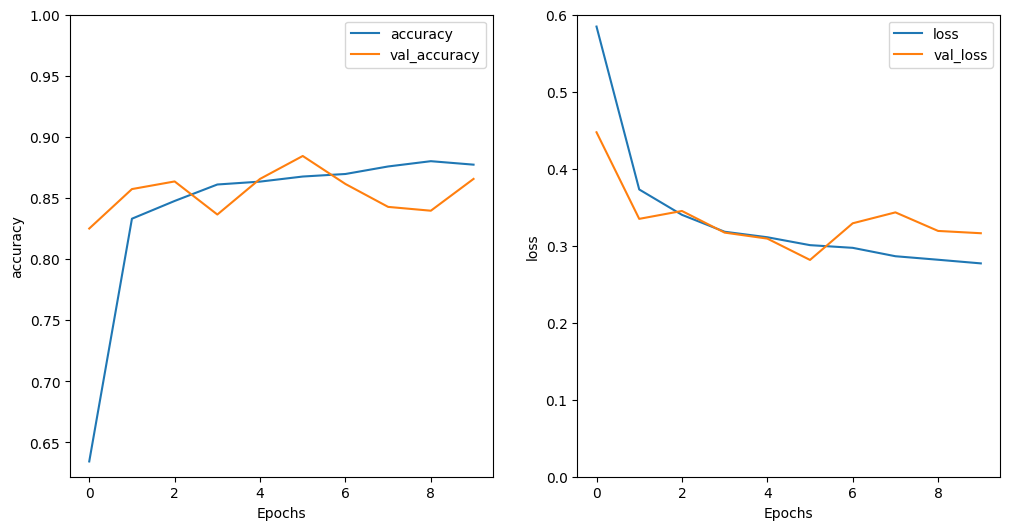

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## **Conclusiones**

- Note que al agregarle al modelo mas capas superiores, logramos mitigar el problema que presentamos en nuestro modelo 2, logrando un *accuracy* del 99.30% en nuestro datos de prueba.
- Como conlusión, cuando hagamos uso de modelo pre-entrenados. Tenemos que hacer uso de todas las herramientas que disponemos, como lo son el *transfer learning* y el *fine tunning*, una caracteristica muy importante que siempre hay que aplicar.